Script to analyze the multiple myeloma results. This includes plotting the representative tree and gene expression analysis.

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import Counter
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from IPython.core.pylabtools import figsize
from networkx.algorithms.bipartite.cluster import clustering
from torchgen.gen_functionalization_type import return_str
from dendropy import Tree, TreeList, TaxonNamespace

from src_python.cell_tree import CellTree

In [18]:
study_num = "mm34" #"bc03"
primary_cells = []

if study_num == "bc03":
    primary_cells = ["SRR5023442", "SRR5023443", "SRR5023444", "SRR5023445", "SRR2973275", "SRR2973351", "SRR2973352", "SRR2973353", "SRR2973354", "SRR2973355", "SRR2973356", "SRR2973357", "SRR2973358", "SRR2973359", "SRR2973360", "SRR2973361", "SRR2973362", "SRR2973363", "SRR2973364", "SRR2973365", "SRR2973366", "SRR2973367", "SRR2973368", "SRR2973369", "SRR2973370", "SRR2973371", "SRR2973372", "SRR2973373", "SRR2973374", "SRR2973375", "SRR2973376", "SRR2973377", "SRR2973378", "SRR2973379", "SRR2973380", "SRR2973381", "SRR2973382", "SRR2973383"]

if study_num == "bc07":
    primary_cells =  ["SRR2973484", "SRR5023558", "SRR5023559", "SRR5023560", "SRR2973277", "SRR2973437", "SRR2973438", "SRR2973439", "SRR2973440", "SRR2973441", "SRR2973442", "SRR2973443", "SRR2973444", "SRR2973445", "SRR2973446", "SRR2973447", "SRR2973448", "SRR2973449", "SRR2973450", "SRR2973451", "SRR2973452", "SRR2973453", "SRR2973454", "SRR2973455", "SRR2973456", "SRR2973457", "SRR2973458", "SRR2973459", "SRR2973460", "SRR2973461", "SRR2973462", "SRR2973463", "SRR2973464", "SRR2973465", "SRR2973466", "SRR2973467", "SRR2973468", "SRR2973469", "SRR2973470", "SRR2973471", "SRR2973472", "SRR2973473", "SRR2973474", "SRR2973475", "SRR2973476", "SRR2973477", "SRR2973478", "SRR2973479", "SRR2973480", "SRR2973481", "SRR2973482", "SRR2973483"]

if study_num == "mm34":
    primary_cells = ["SRR6710302", "SRR6710303", "SRR6710304", "SRR6710305", "SRR6710306", "SRR6710307", "SRR6710308", "SRR6710309", "SRR6710310", "SRR6710311", "SRR6710312", "SRR6710313", "SRR6710314", "SRR6710315", "SRR6710316", "SRR6710317", "SRR6710318", "SRR6710319", "SRR6710320", "SRR6710321", "SRR6710322", "SRR6710323", "SRR6710324", "SRR6710325", "SRR6710326", "SRR6710327", "SRR6710328", "SRR6710329", "SRR6710330", "SRR6710331", "SRR6710332", "SRR6710333", "SRR6710334", "SRR6710335", "SRR6710336", "SRR6710337", "SRR6710338", "SRR6710339", "SRR6710340", "SRR6710341", "SRR6710342", "SRR6710343", "SRR6710344", "SRR6710345", "SRR6710346", "SRR6710347", "SRR6710348", "SRR6710349", "SRR6710350", "SRR6710351", "SRR6710352", "SRR6710353", "SRR6710354", "SRR6710355", "SRR6710356", "SRR6710357", "SRR6710358", "SRR6710359", "SRR6710360", "SRR6710361", "SRR6710362", "SRR6710363", "SRR6710364", "SRR6710365", "SRR6710366"]

if study_num == "mm16":
    primary_cells = ["SRR6710256", "SRR6710257", "SRR6710258", "SRR6710259", "SRR6710260", "SRR6710261", "SRR6710262", "SRR6710263", "SRR6710264", "SRR6710265", "SRR6710266", "SRR6710267", "SRR6710268", "SRR6710269", "SRR6710270", "SRR6710271", "SRR6710272", "SRR6710273", "SRR6710274", "SRR6710275", "SRR6710276", "SRR6710277", "SRR6710278"]

In [26]:
n_bootstrap = 1000
np.random.seed(0)
n_rounds = 3
model = "sciterna"   # "sciterna"
taxa = TaxonNamespace()
trees = TreeList(taxon_namespace=taxa)
path = rf"../data/results/{study_num}/{model}_bootstrap"
split_counter = Counter()

def normalize_split(split):
    A, B = map(set, split)

    if len(A) < 2 or len(B) < 2:
        return None

    side1 = frozenset(A)
    side2 = frozenset(B)

    return frozenset([side1, side2])

def get_splits(ct, node, labels=None):
    splits = []
    for child in ct.dfs_experimental(node):
        if ct.isleaf(child):
            continue

        child_leaves = [leaf for leaf in ct.leaves(child)]
        other_partition = [leaf for leaf in labels if leaf not in child_leaves]

        if 0 < len(child_leaves) < len(labels):
            splits.append((child_leaves, other_partition))

    return splits

def to_newick(ct, node):
    if ct.isleaf(node):
        return f"{node}"
    children = ct.children(node)
    return "(" + ",".join(to_newick(ct, child) for child in children) + f"){node}"

for test in range(n_bootstrap):
    for i in range(2, n_rounds):
        path_parent = os.path.join(path, f"{model}_parent_vec", f"{model}_parent_vec_{i}r{test}.txt")
        path_mut_loc = os.path.join(path, f"{model}_mutation_location", f"{model}_mutation_location_{i}r{test}.txt")
        path_selected = os.path.join(path, f"{model}_selected_loci", f"{model}_selected_loci_{i}r{test}.txt")

        if not os.path.exists(path_parent) or not os.path.exists(path_mut_loc) or not os.path.exists(path_selected):
            continue

        parent_vec = np.loadtxt(path_parent, dtype=int)
        mut_locs = np.loadtxt(path_mut_loc, dtype=int)
        selected_mutations = np.loadtxt(path_selected, dtype=int)

        n_cells = int(((len(parent_vec)+1)/2))

        ct = CellTree(n_cells=n_cells, n_mut=len(selected_mutations))
        ct.use_parent_vec(parent_vec)

        newick_str = to_newick(ct, ct.main_root) + ";"
        tree = Tree.get(data=newick_str, schema="newick", taxon_namespace=taxa)
        trees.append(tree)

        # Count normalized splits
        labels = list(ct.leaves(ct.main_root))
        raw_splits = get_splits(ct, ct.main_root, labels)
        for split in raw_splits:
            norm = normalize_split(split)
            if norm is not None:
                split_counter[norm] += 1

In [28]:
def annotate_clade_frequencies(tree, split_counter, total_trees):
    """
    Annotates each internal node in the consensus tree with its clade frequency
    based on a user-provided split_counter.
    Frequencies are stored in node.label (string, formatted to 2 decimals).
    """
    for node in tree.postorder_node_iter():
        if node.is_leaf():
            continue

        # Get leaf labels on each side of the split
        node_leaves = set(int(leaf.taxon.label) for leaf in node.leaf_iter())
        rest_leaves = set(int(leaf.taxon.label) for leaf in tree.leaf_node_iter()) - node_leaves

        if len(node_leaves) < 2 or len(rest_leaves) < 2:
            continue  # Not a valid split

        split = frozenset([frozenset(node_leaves), frozenset(rest_leaves)])
        freq = split_counter.get(split, 0) / total_trees
        node.label = f"{freq:.3f}"

consensus_tree = trees.consensus(min_freq=0.01, resolve_polytomies=True, suppress_unifurcations=True)
consensus_tree.resolve_polytomies(update_bipartitions=False)
annotate_clade_frequencies(consensus_tree, split_counter, total_trees=n_bootstrap)
print(consensus_tree.as_ascii_plot(show_internal_node_labels=True))

                                                                     /---- 45 
                                                                /----0.019    
                                                                |    \---- 0  
                                                  /-------------0.000         
                                                  |             |    /---- 9  
                                                  |             \----0.013    
                                                  |                  \---- 60 
                                              /---0.000                       
                                              |   |             /--------- 21 
                                              |   |    /--------0.012         
                                              |   |    |        |    /---- 12 
                                              |   |    |        \----0.090    
                                              |   \-

In [25]:
from dendropy import Tree, TaxonNamespace
from dendropy.calculate import treecompare

def split_to_bitmask(split_set, taxon_namespace):
    """
    Convert a set of taxa labels (strings or integers) to a bitmask integer
    based on their position in the taxon namespace.
    """
    label_to_index = {str(t.label): i for i, t in enumerate(taxon_namespace)}
    bitmask = 0
    for label in split_set:
        index = label_to_index[str(label)]
        bitmask |= (1 << index)
    return bitmask

def build_consensus_tree_from_split_counter(split_counter, total_trees, taxon_namespace, min_freq=0.01, is_rooted=True):
    """
    Build a consensus tree from split_counter directly.

    Args:
        split_counter: dict mapping splits (frozenset of frozensets) to counts
        total_trees: total number of trees counted
        taxon_namespace: DendroPy TaxonNamespace
        min_freq: minimum relative frequency to include split
        is_rooted: whether consensus tree should be rooted

    Returns:
        (Tree, dict): DendroPy Tree and split frequencies
    """
    filtered = []
    for split, count in split_counter.items():
        freq = count / total_trees
        if freq >= min_freq:
            part1, part2 = tuple(split)
            # Use smaller side for consistency
            chosen = part1 if len(part1) <= len(part2) else part2
            bitmask = split_to_bitmask(chosen, taxon_namespace)
            filtered.append((freq, bitmask))

    # Sort by decreasing frequency
    filtered.sort(reverse=True, key=lambda x: x[0])
    split_bitmasks = [bitmask for _, bitmask in filtered]
    split_freq_map = {bitmask: freq for freq, bitmask in filtered}

    # Construct the tree
    consensus_tree = Tree.from_split_bitmasks(
        split_bitmasks=split_bitmasks,
        taxon_namespace=taxon_namespace,
        is_rooted=is_rooted
    )

    return consensus_tree, split_freq_map

def annotate_clade_frequencies(tree, split_freq_map):
    """
    Annotate internal nodes with clade frequencies stored in split_freq_map.
    """
    tree.encode_bipartitions()
    for node in tree.postorder_node_iter():
        if node.is_leaf() or node.edge.bipartition is None:
            continue
        bm = node.edge.bipartition.leafset_bitmask
        freq = split_freq_map.get(bm, 0.0)
        node.label = f"{freq:.3f}"

# --- Usage Example ---
consensus_tree, split_freqs = build_consensus_tree_from_split_counter(
    split_counter=split_counter,
    total_trees=n_bootstrap,
    taxon_namespace=taxa,
    min_freq=0.01,
    is_rooted=True
)

consensus_tree.resolve_polytomies(update_bipartitions=True)
annotate_clade_frequencies(consensus_tree, split_freqs)
print(consensus_tree.as_ascii_plot(show_internal_node_labels=True))

                                                                   /------ 45 
                                                            /------0.019      
                                                            |      \------ 0  
                                        /-------------------0.000             
                                        |                   |      /------ 9  
                                        |                   \------0.013      
                                        |                          \------ 60 
                                 /------0.000                                 
                                 |      |                   /------------- 21 
                                 |      |      /------------0.012             
                                 |      |      |            |      /------ 12 
                                 |      |      |            \------0.090      
                                 |      \------0.000

In [33]:
def tree_to_parent_vector(tree):
    """
    Converts a DendroPy Tree object to a parent vector.
    Leaf nodes retain their labels (assumed to be string representations of integers).
    Internal nodes are assigned new labels (as strings of integers) starting from the max leaf label + 1.

    Returns:
        parent_vector: list where index i contains the parent of node i (both as integers)
        node_index_map: dict mapping each node object to its string label
    """
    node_index_map = {}

    # Step 1: Assign leaf labels directly
    leaf_labels = [int(node.taxon.label) for node in tree.leaf_node_iter()]
    max_leaf_label = max(leaf_labels)

    for node in tree.leaf_node_iter():
        node_index_map[node] = node.taxon.label  # Keep leaf labels (as str)

    # Step 2: Assign numeric labels to internal nodes
    next_internal_label = max_leaf_label + 1
    for node in tree.postorder_node_iter():
        if node not in node_index_map:
            node_index_map[node] = str(next_internal_label)
            next_internal_label += 1

    # Step 3: Build parent mapping using labels
    parent_dict = {}
    for parent in tree.preorder_node_iter():
        parent_id = int(node_index_map[parent])
        for child in parent.child_node_iter():
            child_id = int(node_index_map[child])
            parent_dict[child_id] = parent_id

    # Step 4: Build the parent vector list
    total_nodes = next_internal_label
    parent_vector = [-1] * total_nodes  # Initialize with -1 for all nodes

    for child_id, parent_id in parent_dict.items():
        parent_vector[child_id] = parent_id

    return parent_vector, node_index_map

consensus_parent_vec, node_index_map = tree_to_parent_vector(consensus_tree)
print(consensus_parent_vec, len(consensus_parent_vec))

[127, 233, 239, 162, 151, 134, 153, 168, 168, 128, 133, 143, 130, 251, 236, 150, 162, 241, 137, 159, 245, 131, 137, 138, 234, 235, 151, 144, 141, 160, 153, 140, 235, 243, 244, 138, 155, 169, 144, 231, 239, 130, 160, 245, 233, 127, 154, 149, 158, 243, 132, 140, 141, 155, 163, 149, 132, 164, 240, 251, 128, 158, 163, 143, 240, 213, 180, 176, 199, 207, 185, 190, 191, 202, 229, 198, 201, 211, 197, 174, 218, 222, 175, 194, 171, 216, 170, 222, 211, 209, 169, 212, 199, 170, 208, 193, 191, 221, 223, 207, 212, 185, 193, 184, 203, 181, 174, 181, 217, 183, 218, 183, 179, 216, 184, 208, 172, 171, 220, 176, 179, 194, 190, 197, 201, 202, 220, 129, 129, 136, 131, 135, 133, 134, 135, 136, 148, 139, 139, 147, 142, 142, 146, 145, 145, 146, 147, 148, 250, 150, 152, 152, 157, 154, 156, 156, 157, 167, 159, 161, 161, 166, 165, 164, 165, 166, 167, 249, 232, 230, 173, 172, 173, 178, 175, 177, 177, 178, 189, 180, 182, 182, 188, 187, 186, 186, 187, 188, 189, 228, 192, 192, 196, 195, 195, 196, 206, 198, 200, 200,

In [30]:
for split, count in split_counter.most_common(20):
    side1, side2 = list(split)
    shorter_side = sorted(side1) if len(side1) <= len(side2) else sorted(side2)
    print(f"Split: {shorter_side} appears in {count} of {n_bootstrap * (n_rounds - 2)} trees.")

Split: [33, 49] appears in 638 of 1000 trees.
Split: [48, 61] appears in 205 of 1000 trees.
Split: [47, 55] appears in 194 of 1000 trees.
Split: [50, 56] appears in 173 of 1000 trees.
Split: [52, 56] appears in 173 of 1000 trees.
Split: [103, 114] appears in 169 of 1000 trees.
Split: [6, 30] appears in 167 of 1000 trees.
Split: [31, 51] appears in 166 of 1000 trees.
Split: [1, 44] appears in 162 of 1000 trees.
Split: [79, 106] appears in 150 of 1000 trees.
Split: [55, 62] appears in 148 of 1000 trees.
Split: [30, 46] appears in 135 of 1000 trees.
Split: [37, 90] appears in 131 of 1000 trees.
Split: [19, 44] appears in 128 of 1000 trees.
Split: [85, 113] appears in 118 of 1000 trees.
Split: [65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126] appears in 118 of 1000 tr

In [40]:
def plot_consensus_tree(parent_vector, path, support_thresholds=None):
    """
    Plots the consensus tree using Graphviz with node color indicating type and
    border width (black circle) indicating split reliability for internal nodes.

    Args:
        parent_vector (list): Vector where index is the node, value is its parent.
        path (str): Output directory for saving the rendered tree image.
        node_index_map (dict): Mapping from tree nodes to their labels.
        support_thresholds (dict): Mapping of internal node ids (int) to support values (float between 0 and 1).
    """
    n_cells = int((len(parent_vector) + 1) / 2)
    ct = CellTree(n_cells=n_cells, n_mut=0)
    ct.use_parent_vec(parent_vector)
    ct.mut_loc = []

    graph_branches = ct.to_graphviz()

    for node_id in range(len(parent_vector)):
        is_leaf = node_id < n_cells
        node_shape = 'circle'
        node_style = 'filled'
        node_color = 'red' if (is_leaf and node_id in cell_indices) else ('blue' if is_leaf else 'lightgrey')

        # Add border thickness based on reliability (only for internal nodes)
        if not is_leaf and support_thresholds:
            support = support_thresholds.get(str(node_id), 0.0)  # Use string keys if needed
            penwidth = 30 * support  # Scale penwidth with support (e.g., 1–6)
            graph_branches.node(
                str(node_id),
                shape=node_shape,
                style=node_style,
                fillcolor=node_color,
                color='black',
                penwidth=str(penwidth)
            )
        else:
            graph_branches.node(
                str(node_id),
                shape=node_shape,
                style=node_style,
                fillcolor=node_color
            )

    graph_branches.render(os.path.join(path, f"{model}_consensus_tree"), format='png', cleanup=True)

support_thresholds = {}
for node in consensus_tree.postorder_node_iter():
    if not node.is_leaf():
        node_id = int(node_index_map[node])
        try:
            support = float(node.label)
            support_thresholds[str(node_id)] = support
        except (ValueError, TypeError):
            continue  # Skip if label isn't a number

plot_consensus_tree(consensus_parent_vec, path_bootstrap, support_thresholds=support_thresholds)

In [31]:
n_bootstrap = 1000
np.random.seed(0)
n_rounds = 3
model = "sciterna"   # "sciterna"

path = rf"../data/results/{study_num}/{model}"
os.makedirs(os.path.join(path, f"{model}_ct_trees"), exist_ok=True)

ref = np.array(pd.read_csv(os.path.join(f"../data/input_data/{study_num}", "ref.csv")))
cell_names = list(ref[:,0])
cell_indices = [cell_names.index(item) for item in primary_cells if item in cell_names]
ref = ref[:, 1:].astype(int)

alt = np.array(pd.read_csv(os.path.join(f"../data/input_data/{study_num}", "alt.csv")))[:, 1:].astype(int)

def plot_consensus_tree(parent_vector, path):
    n_cells = int(((len(parent_vector)+1)/2))

    ct = CellTree(n_cells=n_cells, n_mut=0)
    ct.use_parent_vec(parent_vector)

    ct.mut_loc = []
    graph_branches = ct.to_graphviz()
    for n in range(n_cells):
        if n in cell_indices:
            graph_branches.node(str(n), shape='circle', style='filled', color="red")
        else:
            graph_branches.node(str(n), shape='circle', style='filled', color="blue") # metastasis

    graph_branches.render(os.path.join(path, f"{model}_consensus_tree"), format='png', cleanup=True)

def plot_trees(path, test, plot_mutations=False, min_num=0):
    for i in range(min_num, n_rounds):
        path_parent = os.path.join(path, f"{model}_parent_vec", f"{model}_parent_vec_{i}{test}.txt")
        path_mut_loc = os.path.join(path, f"{model}_mutation_location", f"{model}_mutation_location_{i}{test}.txt")
        path_selected = os.path.join(path, f"{model}_selected_loci", f"{model}_selected_loci_{i}{test}.txt")

        parent_vec = np.loadtxt(path_parent, dtype=int)
        if os.path.exists(path_mut_loc) == False:
            mut_locs = []
            selected_mutations = []
        else:
            mut_locs = np.loadtxt(path_mut_loc, dtype=int)
            selected_mutations = np.loadtxt(path_selected, dtype=int)

        n_cells = int(((len(parent_vec)+1)/2))

        ct = CellTree(n_cells=n_cells, n_mut=len(selected_mutations))
        ct.use_parent_vec(parent_vec)

        if plot_mutations:
            ct.mut_loc = mut_locs
            graph = ct.to_graphviz()
            graph.render(os.path.join(path, f"{model}_ct_trees", f"ct_tree_{i}{test}"), format='png', cleanup=True)

        ct.mut_loc = []
        graph_branches = ct.to_graphviz()
        for n in range(n_cells):
            if n in cell_indices:
                graph_branches.node(str(n), shape='circle', style='filled', color="red")
            else:
                graph_branches.node(str(n), shape='circle', style='filled', color="blue") # metastasis

        graph_branches.render(os.path.join(path, f"{model}_ct_trees", f"ct_tree_{i}{test}_branches"), format='png', cleanup=True)

if model == "sciterna":
    path_bootstrap = rf"../data/results/{study_num}/{model}_bootstrap"
    os.makedirs(os.path.join(path_bootstrap, f"{model}_ct_trees"), exist_ok=True)

    plot_consensus_tree(consensus_parent_vec, path_bootstrap)
    plot_trees(path, f"r0", plot_mutations=True)

    for i in range(10):
        plot_trees(path_bootstrap, f"r{i}", plot_mutations=False)

else:
    plot_trees(path, "", plot_mutations=True, min_num = 2)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.37607 to fit
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.365068 to fit
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.362094 to fit


KeyboardInterrupt: 

In [9]:
selected = np.loadtxt(os.path.join(path_bootstrap, "selected.txt"), delimiter=',', dtype=int)
ref = pd.read_csv(os.path.join(f"../data/input_data/{study_num}", "ref.csv"))

all_individual_overdispersions_h = np.full((n_bootstrap, ref.shape[1]), np.nan)
all_individual_dropouts = np.full((n_bootstrap, ref.shape[1]), np.nan)

for i in range(n_bootstrap):
    for j in range(n_rounds):
        selected_mutations = np.loadtxt(os.path.join(path_bootstrap, "sciterna_selected_loci", f"sciterna_selected_loci_{j}r{i}.txt"), dtype=int)
        individual_dropouts = np.loadtxt(os.path.join(path_bootstrap, "sciterna_individual_dropout_probs", f"sciterna_individual_dropout_probs_{j}r{i}.txt"))
        individual_overdispersions_h = np.loadtxt(os.path.join(path_bootstrap, "sciterna_individual_overdispersions_h", f"sciterna_individual_overdispersions_h_{j}r{i}.txt"))

        unique_mutations = np.unique(selected_mutations)
        for mut in unique_mutations:
            indices = np.where(selected_mutations == mut)[0]
            mean_dropout = np.mean(individual_dropouts[indices])
            mean_overdispersion = np.mean(individual_overdispersions_h[indices])

            all_individual_dropouts[i, mut] = mean_dropout
            all_individual_overdispersions_h[i, mut] = mean_overdispersion

KeyboardInterrupt: 

In [24]:
sufficient_data_columns_od = ~(np.any(all_individual_overdispersions_h == 6, axis=0))
sufficient_data_columns_dropout = ~(np.any(all_individual_dropouts == 0.2, axis=0))

mean_overdispersions = np.nanmean(all_individual_overdispersions_h[:, sufficient_data_columns_od], axis=0)
mean_dropouts = np.nanmean(all_individual_dropouts[:, sufficient_data_columns_dropout], axis=0)

C:\Users\Norio\AppData\Local\Temp\ipykernel_30248\246939900.py:4: RuntimeWarning: Mean of empty slice
  mean_overdispersions = np.nanmean(all_individual_overdispersions_h[:, sufficient_data_columns_od], axis=0)
C:\Users\Norio\AppData\Local\Temp\ipykernel_30248\246939900.py:5: RuntimeWarning: Mean of empty slice
  mean_dropouts = np.nanmean(all_individual_dropouts[:, sufficient_data_columns_dropout], axis=0)


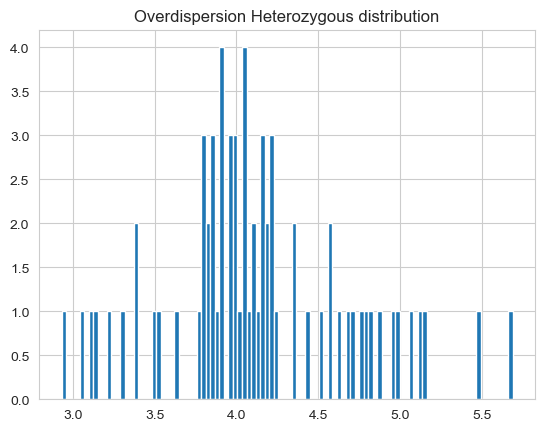

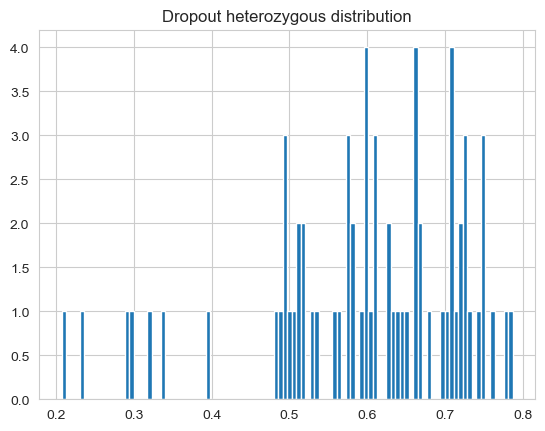

In [25]:
plt.hist(mean_overdispersions, bins=100)
plt.title("Overdispersion Heterozygous distribution")
plt.show()

plt.hist(mean_dropouts, bins=100)
plt.title("Dropout heterozygous distribution")
plt.show()

In [52]:
def create_mutation_matrix(parent_vector, mutation_indices, ct):
    n_nodes = len(parent_vector)
    n_leaves = int((n_nodes+1)/2)
    n_mutations = len(mutation_indices)

    mutation_matrix = np.zeros((n_nodes, n_mutations), dtype=int)

    for mutation_idx, cell_idx in enumerate(mutation_indices):
        children = [c for c in ct.dfs(cell_idx)]
        for cell in children:  # Traverse all cells below the mutation cell
            mutation_matrix[cell, mutation_idx] = 1  # Mark cells with the mutation

    return mutation_matrix[:n_leaves].T

def are_all_arrays_identical(arrays_list):
    first_array = arrays_list[0]
    return all(np.array_equal(first_array, array) for array in arrays_list[1:])

In [53]:
# with open("../data/input_data/gencode.v21.annotation.gtf", 'r') as file:
#     for line in file:
#         if line.startswith("#"):
#                 continue
#         fields = line.strip().split('\t')
#         if fields[2] == 'gene':
#             attributes = {key_value.split(' ')[0]: key_value.split(' ')[1].strip('"') for key_value in
#                           fields[8].split('; ') if key_value}
#             gene_names.append([fields[0], fields[3], fields[4], attributes["gene_name"]])
# 
# df = pd.DataFrame(gene_names, columns=['chromosome', 'start', 'end', 'gene'])
# df['start'] = df['start'].astype(int)
# df['end'] = df['end'].astype(int)
# df.to_csv("../data/input_data/mm34/gene_positions.csv", index=False)

def convert_location_to_gene(locs):

    loc_to_gene = []

    df = pd.read_csv("../data/input_data/mm34/gene_positions.csv", index_col=False)
    for location in locs:
        chrom, pos = location.split(":")[0], location.split(":")[1]
        pos = int(pos)
        matching_rows = df[(df['chromosome'] == chrom) & (df['start'] <= pos) & (df['end'] >= pos)]
        matching_genes = matching_rows['gene'].tolist()
        loc_to_gene.append(matching_genes)

    return loc_to_gene

In [54]:
n_bootstrap = 1000
np.random.seed(0)
use_summary_statistics = False # Uses the summary files saved in the data/ directory. If raw output files were generated, set to False

path = rf"../data/results/{study_num}/sciterna_bootstrap"

reference = pd.read_csv(rf'../data/input_data/{study_num}/ref.csv', index_col=0)

if use_summary_statistics == False:
    os.makedirs(os.path.join(path, "sciterna_mutations_before_branching"), exist_ok=True)
    os.makedirs(os.path.join(path, "sciterna_nodes_after_branching"), exist_ok=True)
    os.makedirs(os.path.join(path, "sciterna_nodes_before_branching"), exist_ok=True)
    os.makedirs(os.path.join(path, "sciterna_mutations_branching"), exist_ok=True)
    os.makedirs(os.path.join(path, "sciterna_mutations_after_branching"), exist_ok=True)
    
    all_loci = reference.columns
    all_cells = reference.index
    mut_indicator = {}
    
    def mutations_node(parent_vector, mutation_indices, ct, node):
        n_cells = len(parent_vector)
        n_mutations = len(mutation_indices)
    
        mutation_matrix = np.zeros((n_cells, n_mutations), dtype=int)
    
        for mutation_idx, cell_idx in enumerate(mutation_indices):
            children = [c for c in ct.dfs_experimental(cell_idx)]
            for cell in children:  # Traverse all cells below the mutation cell
                mutation_matrix[cell, mutation_idx] = 1  # Mark cells with the mutation
    
        return mutation_matrix[node]
    
    for i in range(0, n_bootstrap):
        for r in range(n_rounds):
            path_parent = os.path.join(path, "sciterna_parent_vec", f"sciterna_parent_vec_{r}r{i}.txt")

            if os.path.exists(os.path.join(path, rf"sciterna_mutations_branching\mutations_branching_{r}r{i}.txt")):
                continue

            path_mut_loc = os.path.join(path, "sciterna_mutation_location", f"sciterna_mutation_location_{r}r{i}.txt")
            path_selected = os.path.join(path, "sciterna_selected_loci", f"sciterna_selected_loci_{r}r{i}.txt")
            parent_vec = np.loadtxt(path_parent, dtype=int)
            mut_locs = np.loadtxt(path_mut_loc, dtype=int)
            mutations = np.loadtxt(path_selected)
            for loci in all_loci:
                mut_indicator[loci] = []

            n_cells = int(((len(parent_vec)+1)/2))
            ct = CellTree(n_cells=n_cells, n_mut=len(mutations))
            ct.use_parent_vec(parent_vec)
            ct.mut_loc = mut_locs

            # mutation_matrix = create_mutation_matrix(ct.parent_vec, ct.mut_loc, ct)
            #
            # for mi, mut in enumerate(mutations):
            #     mut_indicator[all_loci[int(mut)]].append(mutation_matrix[mi])
            #
            # for k in mut_indicator.keys():
            #     if len(mut_indicator[k]) > 1:
            #         if not are_all_arrays_identical(mut_indicator[k]):
            #             print("Problem")
            #         else:
            #             mut_indicator[k] = [mut_indicator[k][0]]
            #
            # dataframe = {}
            #
            # for key, value in mut_indicator.items():
            #     if len(value) > 0:
            #         dataframe[key] = pd.DataFrame([value[0]], columns=all_cells)
            #     else:
            #         dataframe[key] = pd.DataFrame([np.nan] * len(all_cells)).T
            #         dataframe[key].columns = all_cells
            #
            # df = pd.concat(dataframe.values(), axis=0)
            # df.index = all_loci
            # df.to_csv(os.path.join(path, "sciterna_mut_indicator", f"sciterna_mut_indicator_{r}r{i}.csv"), index=True)

            # optimize capture rate + purity to determine the majority metastasis branch
            branching_node = 0
            branching_nodes_max = 0
            for node in range(len(parent_vec)):
                if ct.isleaf(node):
                    continue

                primary = 0
                metastasis = 0
                for sn in ct.dfs_experimental(node):
                    if ct.isleaf(sn):
                        if sn in cell_indices:
                            primary += 1
                        else:
                            metastasis += 1

                capture_rate = metastasis/(n_cells - len(cell_indices))
                purity = metastasis/(metastasis + primary)
                branching_nodes_new = capture_rate + purity

                if branching_nodes_max < branching_nodes_new:
                    branching_node = node
                    branching_nodes_max = branching_nodes_new
            print(branching_node, branching_nodes_max)
            if branching_nodes_max < 1.7:
                print("Potential problem (Likely wrong root): ", i, r)

            mutations_indices = mutations_node(parent_vec, mut_locs, ct, branching_node)
            mutations_branching = mutations[mutations_indices==1]
            np.savetxt(os.path.join(path, rf"sciterna_mutations_branching\mutations_branching_{r}r{i}.txt"), mutations_branching, fmt='%i')

            mutations_after_metastasis = []
            metastasis_nodes = [n for n in ct.dfs_experimental(branching_node) if ct.isleaf(n)]
            primary_nodes = [n for n in range(n_cells) if n not in metastasis_nodes]

            np.savetxt(os.path.join(path, rf"sciterna_nodes_after_branching\nodes_after_branching_{r}r{i}.txt"), metastasis_nodes, fmt='%i')
            np.savetxt(os.path.join(path, rf"sciterna_nodes_before_branching\nodes_before_branching_{r}r{i}.txt"), primary_nodes, fmt='%i')

            for ni, mut_loc in enumerate(mut_locs):
                if mut_loc in metastasis_nodes[1:]:
                    mutations_after_metastasis.append(mutations[ni])

            mutations_before_metastasis = [m for m in mutations if m not in mutations_after_metastasis]

            np.savetxt(os.path.join(path, rf"sciterna_mutations_before_branching\mutations_before_branching_{r}r{i}.txt"), mutations_before_metastasis, fmt='%i')
            np.savetxt(os.path.join(path, rf"sciterna_mutations_after_branching\mutations_after_branching_{r}r{i}.txt"), mutations_after_metastasis, fmt='%i')

In [55]:
if use_summary_statistics == False:
    primary = []
    metastasis = []
    primary_nodes = []
    metastasis_nodes = []
    branching = []
    r = 2
    for i in range(n_bootstrap):
        path_primary_node = os.path.join(path, rf"sciterna_nodes_before_branching\nodes_before_branching_{r}r{i}.txt")
        path_metastasis_node = os.path.join(path, rf"sciterna_nodes_after_branching\nodes_after_branching_{r}r{i}.txt")
        path_primary = os.path.join(path, rf"sciterna_mutations_before_branching\mutations_before_branching_{r}r{i}.txt")
        path_metastasis = os.path.join(path, rf"sciterna_mutations_after_branching\mutations_after_branching_{r}r{i}.txt")
        path_branching = os.path.join(path, rf"sciterna_mutations_branching\mutations_branching_{r}r{i}.txt")

        primary_data = np.atleast_1d(np.loadtxt(path_primary, dtype=int))
        metastasis_data = np.atleast_1d(np.loadtxt(path_metastasis, dtype=int))
        primary_nodes_data = np.atleast_1d(np.loadtxt(path_primary_node, dtype=int))
        metastasis_nodes_data = np.atleast_1d(np.loadtxt(path_metastasis_node, dtype=int))
        branching_data = np.atleast_1d(np.loadtxt(path_branching, dtype=int))

        primary.extend(primary_data)
        metastasis.extend(metastasis_data)
        primary_nodes.extend(primary_nodes_data)
        metastasis_nodes.extend(metastasis_nodes_data)
        branching.extend(branching_data)
        
    unique_mutations_branching, counts_mutations_branching = np.unique(np.array(branching), return_counts=True)
    selected = np.loadtxt(os.path.join(path, "selected.txt"), delimiter=',', dtype=int)
    selected_mutations = np.unique(selected)

else:
    metastasis_nodes = np.loadtxt(os.path.join(path, "metastasis_nodes.txt"))

C:\Users\Norio\AppData\Local\Temp\ipykernel_30248\121701500.py:17: UserWarning: loadtxt: input contained no data: "../data/results/mm34/sciterna_bootstrap\sciterna_nodes_before_branching\nodes_before_branching_2r6.txt"
  primary_nodes_data = np.atleast_1d(np.loadtxt(path_primary_node, dtype=int))
C:\Users\Norio\AppData\Local\Temp\ipykernel_30248\121701500.py:19: UserWarning: loadtxt: input contained no data: "../data/results/mm34/sciterna_bootstrap\sciterna_mutations_branching\mutations_branching_2r6.txt"
  branching_data = np.atleast_1d(np.loadtxt(path_branching, dtype=int))
C:\Users\Norio\AppData\Local\Temp\ipykernel_30248\121701500.py:17: UserWarning: loadtxt: input contained no data: "../data/results/mm34/sciterna_bootstrap\sciterna_nodes_before_branching\nodes_before_branching_2r271.txt"
  primary_nodes_data = np.atleast_1d(np.loadtxt(path_primary_node, dtype=int))
C:\Users\Norio\AppData\Local\Temp\ipykernel_30248\121701500.py:19: UserWarning: loadtxt: input contained no data: "..

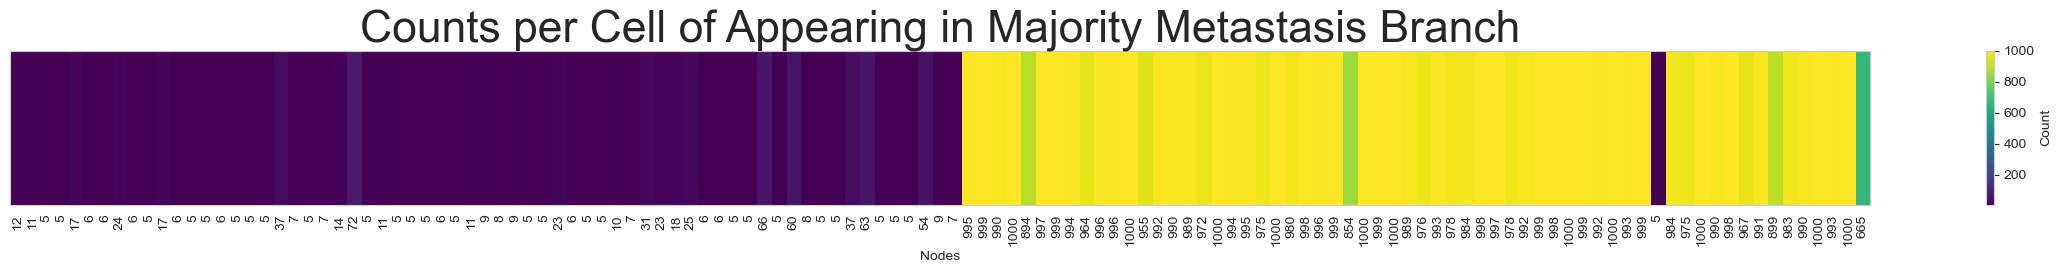

In [56]:
unique_cells, posterior_node_after_branching = np.unique(np.array(metastasis_nodes), return_counts=True)
heatmap_data = posterior_node_after_branching.reshape(1, -1)
plt.figure(figsize=(30, 2))
plt.imshow(heatmap_data, cmap='viridis', aspect='auto')
plt.colorbar(label='Count')
plt.xticks(ticks=np.arange(len(unique_cells)), labels=posterior_node_after_branching, rotation=90)
plt.yticks([])
plt.xlabel('Nodes')
plt.title('Counts per Cell of Appearing in Majority Metastasis Branch', fontsize=32)
plt.grid(False)

plt.show()

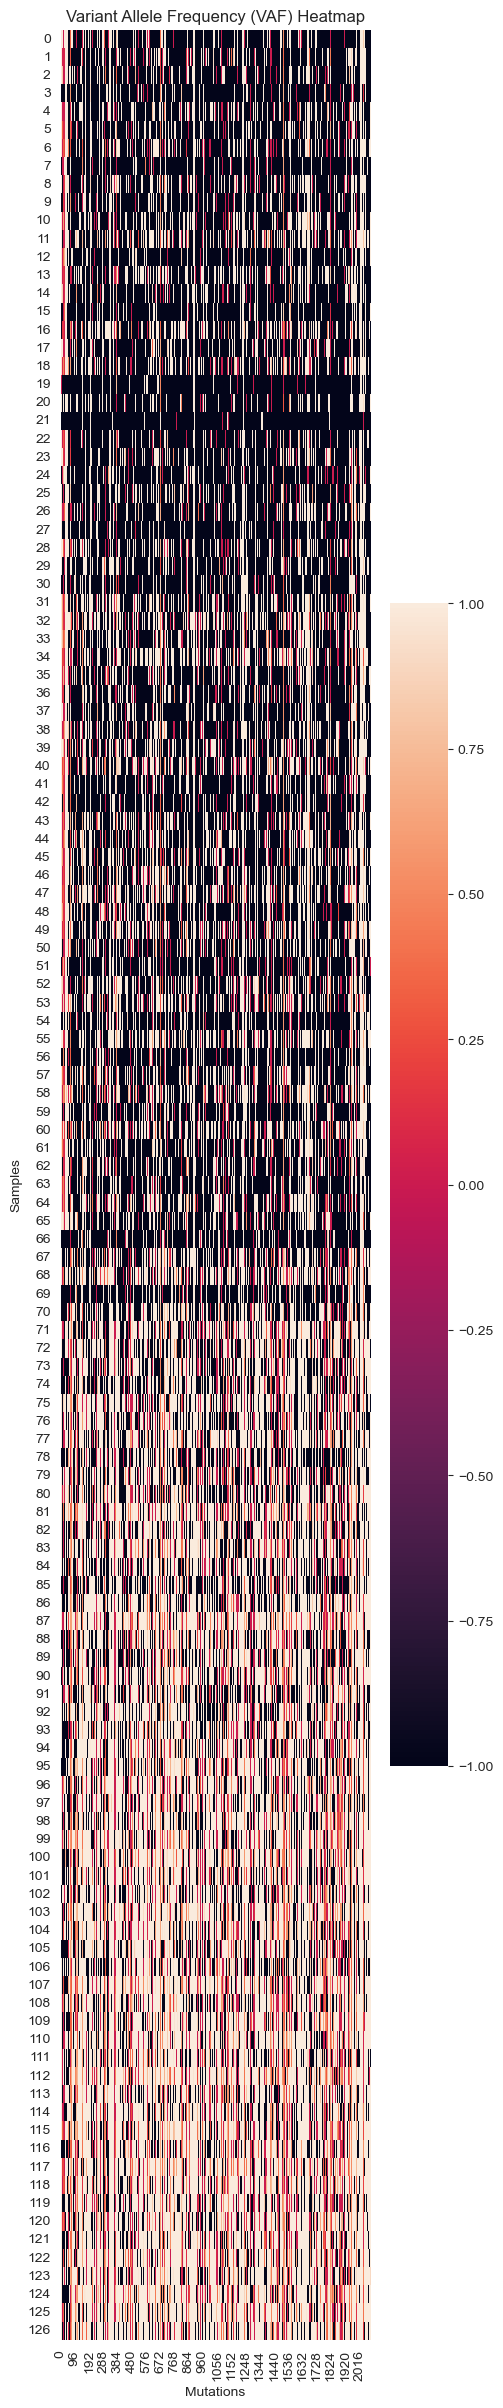

In [57]:
import seaborn as sns

ref = np.array(pd.read_csv(os.path.join(f"../data/input_data/{study_num}", "ref.csv")))
cell_names = list(ref[:,0])
cell_indices = [cell_names.index(item) for item in primary_cells if item in cell_names]
ref = ref[:, 1:].astype(int)

alt = np.array(pd.read_csv(os.path.join(f"../data/input_data/{study_num}", "alt.csv")))[:, 1:].astype(int)

indices_sorted = np.argsort(posterior_node_after_branching) #cell_indices + [c for c in np.arange(len(posterior_node_after_branching)) if c not in cell_indices]

vaf = np.divide(alt, ref + alt, out=np.full_like(alt, -1, dtype=float), where=(ref + alt) != 0)
vaf = np.array(vaf, dtype=float)[indices_sorted]

plt.figure(figsize=(5,30))
sns.heatmap(vaf)
plt.title("Variant Allele Frequency (VAF) Heatmap")
plt.ylabel("Samples")
plt.xlabel("Mutations")
plt.show()

In [58]:
top_loci = np.loadtxt(rf"../data/results/{study_num}/sciterna_bootstrap/selected.txt", dtype=int)

In [59]:
selected_loci = reference.columns[top_loci]
selected_genes = convert_location_to_gene(selected_loci)

IndexError: index 2094 is out of bounds for axis 0 with size 2092

In [39]:
genes = []
for s in selected_genes:
    genes.extend(s)
gens, cnt = np.unique(genes, return_counts=True)

print(cnt[np.argsort(cnt)][-30:])
print(gens[np.argsort(cnt)][-30:])

[ 2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  5  5
  5  5  5  6  8 17]
['CD38' 'CPEB4' 'IGHG4' 'IGKV3-11' 'RP11-234A1.1' 'IGKV1-8' 'IER3IP1'
 'UBE2H' 'HSPA8' 'CHD2' 'ZSWIM6' 'NOP10' 'STK17A' 'SSR3' 'PICALM'
 'FAM133B' 'SLC25A45' 'RP11-514P8.6' 'NPIPB4' 'POLR2J2' 'COA1' 'UPK3BL'
 'CNTN5' 'IGHV1-2' 'IGHG3' 'HCLS1' 'IGHM' 'FNDC3B' 'IGHG1' 'LINC-PINT']


In [60]:
expression_counts = pd.read_csv(rf"../data/input_data/{study_num}/gene_expression_counts.csv", index_col=0)
normalized_counts = expression_counts.div(expression_counts.sum(axis=1), axis=0) * 1e5
expression_counts_scaled = np.log1p(normalized_counts)

expression_counts_scaled['sum_counts'] = expression_counts_scaled.sum(axis=1)
df_sorted = expression_counts_scaled.sort_values(by='sum_counts', ascending=False)
top_1000 = df_sorted.head(1000)
top_1000 = top_1000.drop(columns=['sum_counts'])
expression_counts_scaled = expression_counts_scaled.drop(columns=['sum_counts'])

In [61]:
top_indices = np.argsort(np.mean(expression_counts_scaled, axis=1))[-50:]
top_rows = expression_counts_scaled.iloc[top_indices]
top_rows

,SRR6710302,SRR6710303,SRR6710304,SRR6710305,SRR6710306,SRR6710307,SRR6710308,SRR6710309,SRR6710310,SRR6710311,...,SRR6710419,SRR6710420,SRR6710421,SRR6710422,SRR6710423,SRR6710424,SRR6710425,SRR6710426,SRR6710427,SRR6710428
PTMAP2,6.332920,7.267933,6.332920,6.227757,8.262921,6.862817,4.730565,5.641548,6.973932,8.147883,...,7.679677,6.668885,6.472450,0.000000,6.332920,6.514946,5.641548,6.862817,7.754679,5.823279
TPT1,7.133817,6.699253,2.615111,5.778110,5.996463,6.766974,6.920620,7.638240,5.503640,5.897148,...,6.644599,6.679634,6.824795,3.145656,7.128648,6.020608,6.255129,6.099642,6.718806,1.033120
RPL35A,7.346241,7.483360,6.024118,6.079018,6.465459,6.817636,6.219838,7.299333,7.132645,6.833607,...,6.581827,5.524395,7.286149,2.465079,7.505116,6.969272,6.842072,6.988321,7.105634,7.078781
EEF1A1P12,6.435613,6.905016,5.235375,4.147356,6.575166,6.950780,6.043343,6.857056,6.384404,6.530778,...,6.771627,6.735302,7.549677,0.000000,7.573957,7.076707,6.920504,6.965581,7.102661,0.000000
AC016739.2,7.285536,7.521220,4.544002,6.432045,6.480759,4.829023,6.654867,7.460630,6.480759,6.990971,...,6.901445,6.432045,7.046491,4.143839,7.219624,6.654867,6.480759,6.614099,7.046491,0.000000
RPS8,7.007094,7.959311,6.372805,5.556713,7.150950,4.679372,6.553682,6.632162,7.254793,7.436937,...,7.159896,6.602888,7.324315,4.577402,7.223717,6.310002,6.693952,6.660930,6.468118,1.110961
RPS25,6.978209,6.684224,5.055932,5.882917,6.303140,5.536078,6.727466,7.431296,6.007871,6.922744,...,7.231550,6.896989,7.713761,3.801806,7.638489,7.172704,7.150149,7.197833,7.349902,1.419705
RPS27,5.902741,6.710130,4.319058,5.496647,5.066275,5.925229,6.260212,7.298858,5.965374,6.197149,...,7.363400,7.258290,7.641503,3.640094,7.340974,7.184893,7.188153,7.238448,7.298858,4.464464
AC016708.2,6.360766,7.926575,5.634377,6.289435,6.842955,6.548522,6.754107,7.812427,7.053048,7.151407,...,6.706536,6.519576,7.255127,4.791832,7.423154,6.799518,6.604014,6.904767,6.489768,4.791832
EEF1A1P9,6.463249,7.231067,5.424650,5.424650,6.338294,6.482637,6.848412,5.828645,6.402722,6.338294,...,7.019393,6.793664,7.275487,0.000000,7.334536,7.284139,6.381703,6.949662,7.052516,0.000000


In [62]:
categories = {
    # "Most expressed": ["IGKV2-28", "B2M", "MALAT1"],
    # "largest_difference_groups": ['IGJ', 'FCRL2', 'CD74', 'ABCA1', 'TBL1XR1', 'HLA-B'], #'CTSB'
    "selected": ['CTSB', "IGHV1-2", "B2M", 'IGHM', 'FNDC3B', 'IGHG1', 'LINC-PINT', "MT-ND2", "FTL", "IGKC", "CD138"],
    # "most_mutated": ['DCC', 'PELI1', 'NBPF14', 'VPS41', 'ATP11B'] # 'CTSB'
}

filtered_df_top_genes = pd.DataFrame()

for category, genes in categories.items():
    category_genes = expression_counts_scaled[expression_counts_scaled.index.isin(genes)]
    category_row_sums = category_genes.sum(axis=1)
    top_genes = category_row_sums.nlargest(7).index
    filtered_df_top_genes = pd.concat([filtered_df_top_genes, expression_counts_scaled.loc[top_genes]])

In [63]:
filtered_df_top_genes = top_rows

<Figure size 4000x1600 with 0 Axes>

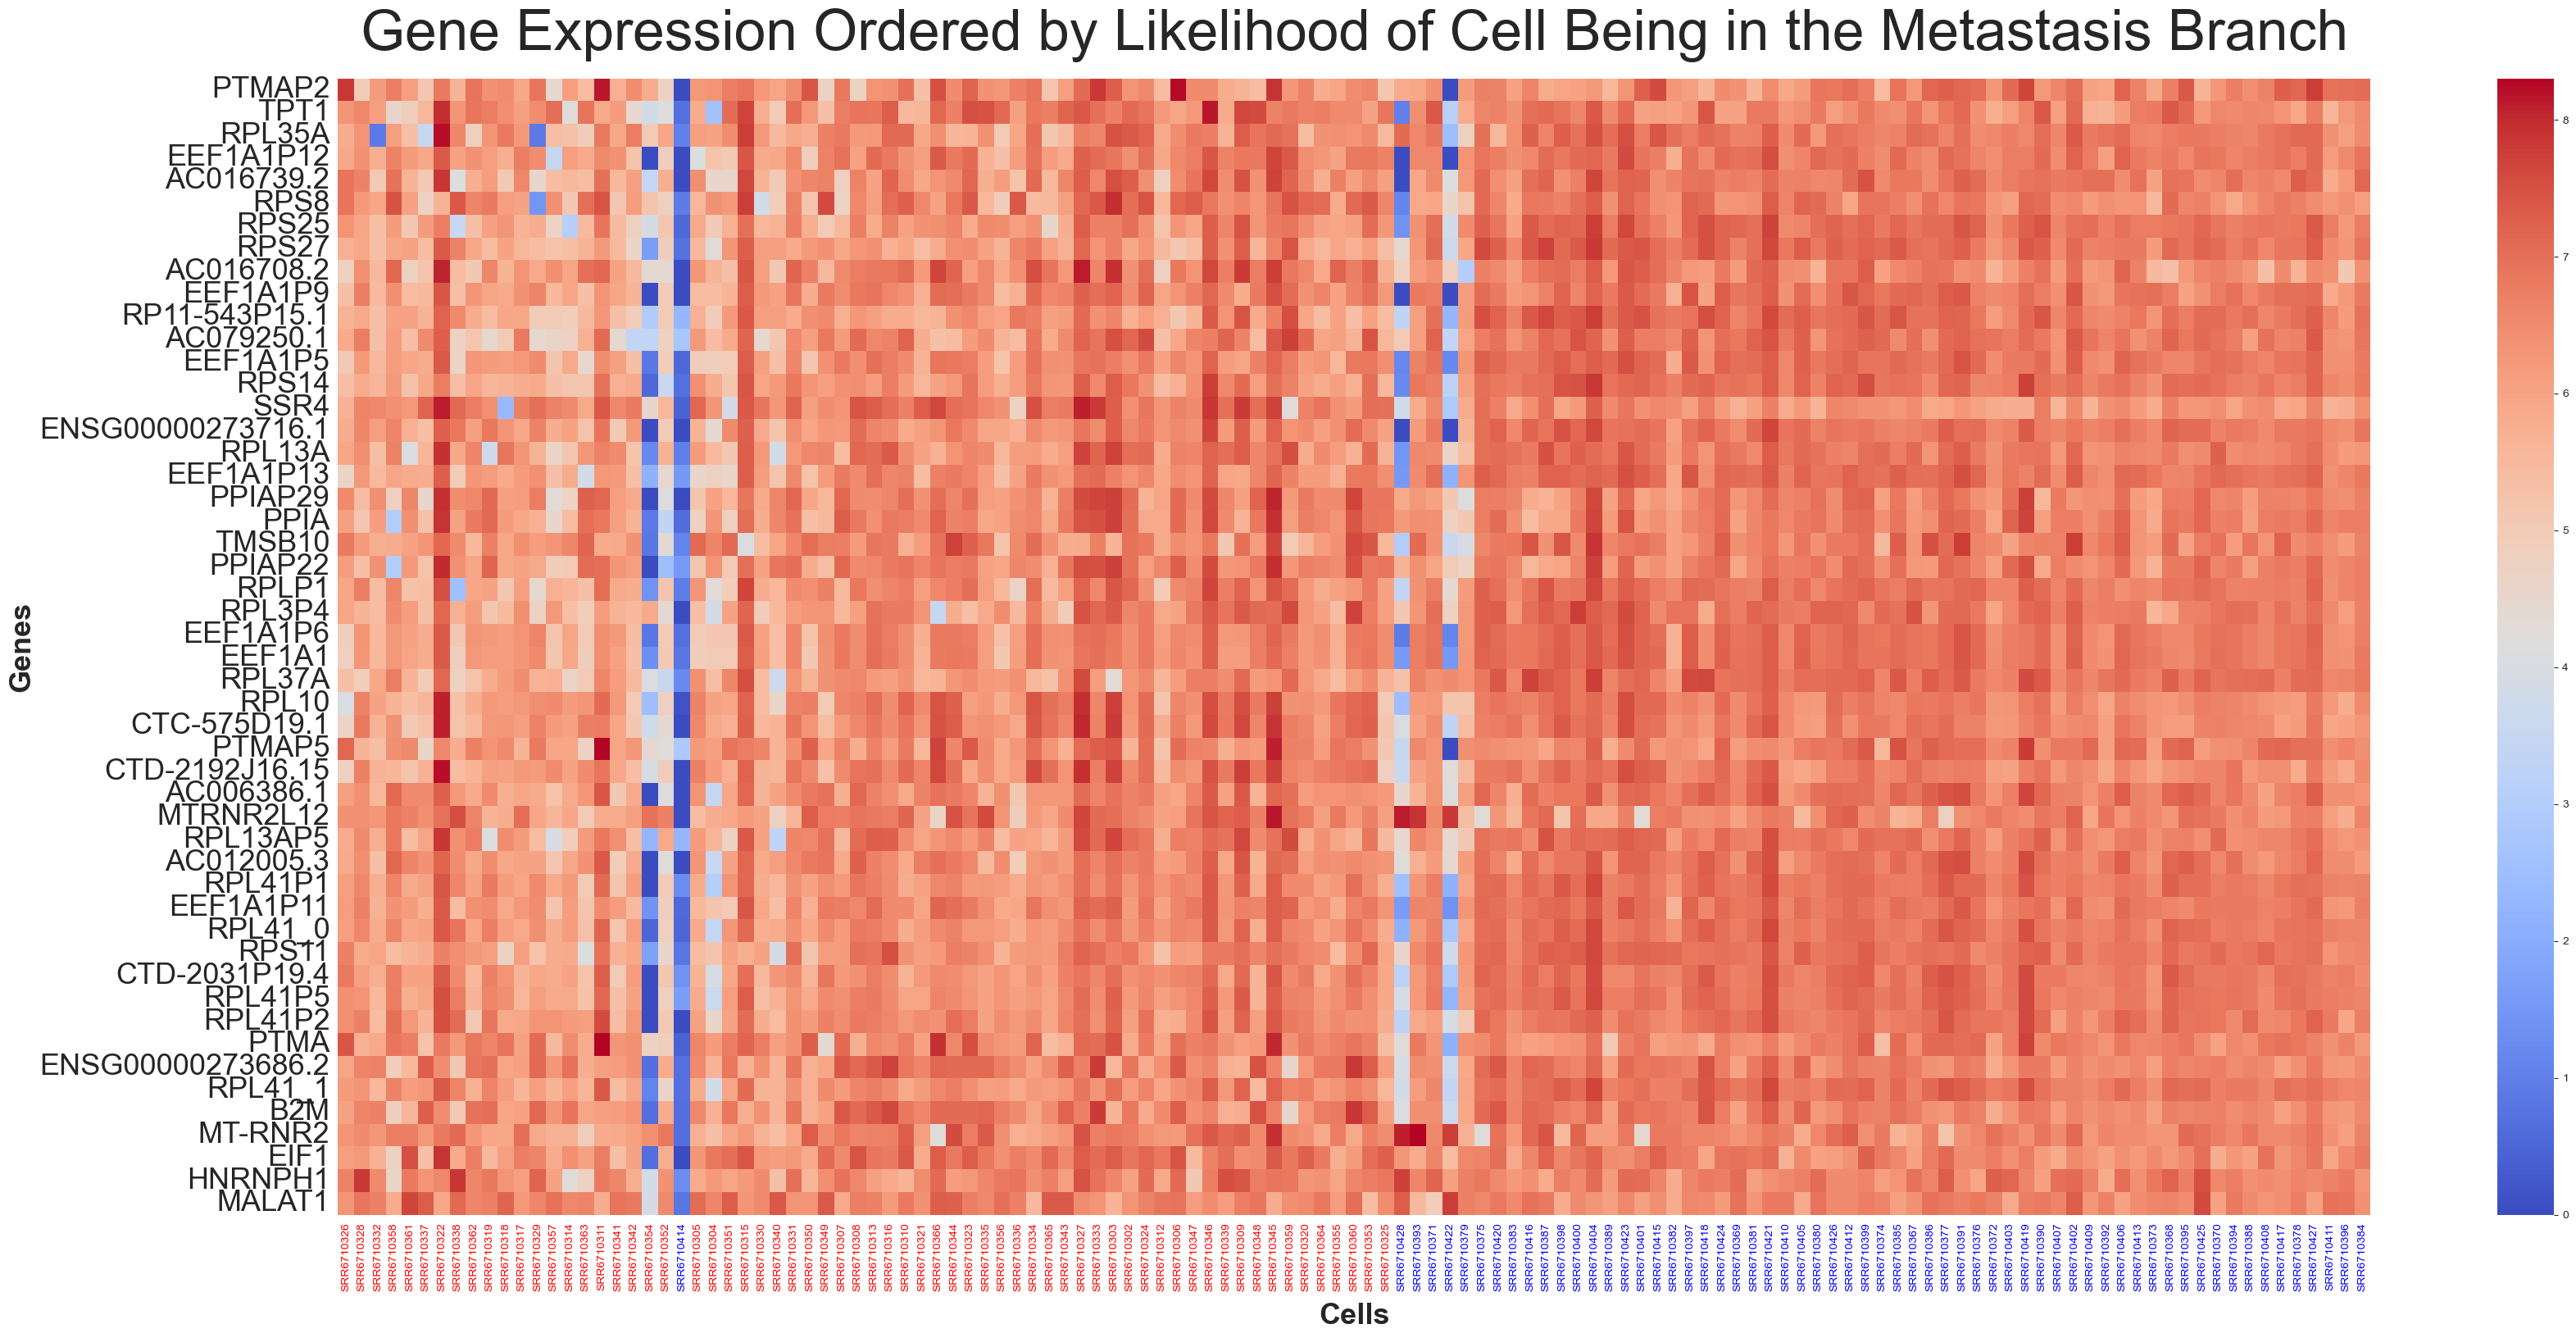

In [65]:
sorted_indices = cell_indices + [c for c in np.arange(len(posterior_node_after_branching)) if c not in cell_indices] #
# np.argsort(posterior_node_after_branching)

plt.figure(figsize=(40, 16))

sorted_df = filtered_df_top_genes .iloc[:, sorted_indices]
col_colors = ['red' if val in cell_indices else 'blue' for val in sorted_indices]

plt.figure(figsize=(40, 18))
ax = sns.heatmap(sorted_df, cmap='coolwarm')

for n, tick_label in enumerate(ax.get_xticklabels()):
    tick_label.set_color(col_colors[n])
        
for tick_label in ax.get_yticklabels():
    tick_label.set_fontsize(26)   
    tick_label.set_rotation(0)
    
# for idx in [3,9,10]:
#     plt.hlines(idx, *plt.xlim(), color='black', linewidth=4)
    
# plt.text(1.02, 0.91, "Most Expressed", va='center', ha='left', fontsize=24, fontweight='bold', rotation=90, transform=plt.gca().transAxes)
# plt.text(1.02, 0.58, "Largest Difference Samples", va='center', ha='left', fontsize=24, fontweight='bold', rotation=90, transform=plt.gca().transAxes)
# plt.text(1.02, 0.18, "Most SNVs", va='center', ha='left', fontsize=24, fontweight='bold', rotation=90, transform=plt.gca().transAxes)
plt.title("Gene Expression Ordered by Likelihood of Cell Being in the Metastasis Branch", fontsize=50, pad=25)
plt.ylabel("Genes", fontsize=26, fontweight='bold')
plt.xlabel("Cells", fontsize=26, fontweight='bold', labelpad=10)
# plt.savefig(r"../data/results/figures/gene_expression.pdf", format="pdf")
plt.show()

In [94]:
r = 2
path = rf"../data/results/{study_num}/sciterna"
reference = pd.read_csv(rf'../data/input_data/{study_num}/ref.csv', index_col=0)
path_parent = os.path.join(path, "sciterna_parent_vec", f"sciterna_parent_vec_{r}r0.txt")
path_mut_loc = os.path.join(path, "sciterna_mutation_location", f"sciterna_mutation_location_{r}r0.txt")
path_selected = os.path.join(path, "sciterna_selected_loci", f"sciterna_selected_loci_{r}r0.txt")
parent_vec = np.loadtxt(path_parent, dtype=int)
mut_locs = np.loadtxt(path_mut_loc, dtype=int)
selected_mutations = np.loadtxt(path_selected, dtype=int)

selected_loci = reference.columns[selected_mutations]
selected_genes = convert_location_to_gene(selected_loci)

ctsb_indices = [n for n, c in enumerate(selected_genes) if "CTSB" in c]

In [93]:
n_cells = int(((len(parent_vec)+1)/2))
ct = CellTree(n_cells=n_cells, n_mut=0)
ct.use_parent_vec(parent_vec)
ct.mut_loc = mut_locs[ctsb_indices]

graph = ct.to_graphviz(gene_names=["C" for _ in range(3000)])
graph.attr(dpi='50')
graph.attr(rankdir='LR')

color_row = filtered_df_top_genes.loc["CTSB"].values
color_row = color_row / np.max(color_row)

cmap = plt.get_cmap('Greens')
colors = cmap(color_row)

for n in range(int((len(parent_vec)+1)/2)):
    rgba_color = colors[n]
    hex_color = mcolors.to_hex(rgba_color)

    if n in cell_indices:
        prob = (np.max(posterior_node_after_branching) - posterior_node_after_branching[n]) / np.max(posterior_node_after_branching)
        graph.node(str(n), label="", shape='circle', style='filled', color="red", 
                   fillcolor=hex_color, fixedsize="true", width=str(prob), height=str(prob), penwidth="10")
    else: # metastasis
        prob = posterior_node_after_branching[n] / np.max(posterior_node_after_branching)
        graph.node(str(n), label="", shape='circle', style='filled', fillcolor=hex_color, 
                   color="blue", fixedsize="true", width=str(prob), height=str(prob), penwidth="15")
graph.attr(ratio="0.23") 

graph_file = "../data/results/figures/representative_tree"
graph.render(graph_file, format='pdf', cleanup=True)

'..\\data\\results\\figures\\representative_tree.pdf'

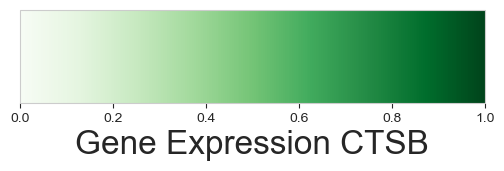

In [95]:
fig, ax = plt.subplots(figsize=(6, 1))
norm = mcolors.Normalize(vmin=0, vmax=1)
sm = cm.ScalarMappable(cmap='Greens', norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', fraction=2, pad=0, aspect=5)
cbar.set_label('Gene Expression CTSB', fontsize=24)
cbar.ax.tick_params(labelsize=10)
ax.axis('off')
colorbar_path = os.path.join(path, "gene_expression_colorbar.svg")
plt.show()